In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
# import imutils
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from collections import Counter
import pandas as pd

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU instead.")

Using GPU: NVIDIA GeForce RTX 2070 SUPER


In [ ]:
NUM_EPOCHS = 20
BATCH_SIZE = 32

## Data Processing

In [3]:
label_map = {'notumor': 0, 'glioma': 1, 'meningioma': 2, 'pituitary': 3}
# image_size = 200

# from https://github.com/pytorch/vision/issues/6192
def gauss_noise_tensor(img):
    assert isinstance(img, torch.Tensor)
    dtype = img.dtype
    if not img.is_floating_point():
        img = img.to(torch.float32)
    
    sigma = 0.05
    
    out = img + sigma * torch.randn_like(img)
    
    if out.dtype != dtype:
        out = out.to(dtype)
        
    return out

flip_transform = transforms.Compose([
    gauss_noise_tensor,
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize((0.5,), (0.5,))
])

simple_transform = transforms.Compose([
    transforms.Normalize((0.5,), (0.5,))
])

def load_images(base_path):
    images = []
    labels = []

    image_to_tensor = transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])
    
    for label in label_map.keys():
        path = os.path.join(base_path, label)
        for file in tqdm(os.listdir(path)):
            file_path = os.path.join(path, file)

            # process image
            image = Image.open(file_path).convert('L')
            image = image_to_tensor(image)
            images.append(image)
            
            # (binary label, multiclass label)
            labels.append((label_map[label]))
    
    return images, labels

all_images, all_labels = load_images('./preprocessed_data/')

x_train, x_test, y_multi_train, y_multi_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=69)

100%|██████████| 1740/1740 [00:01<00:00, 1647.56it/s]


In [4]:
from torch.utils.data import Dataset

# I don't want to deal with the ImageFolder loader
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [5]:
y_binary_train = [int(label != 0) for label in y_multi_train]
y_binary_test =  [int(label != 0) for label in y_multi_test]

print("Label Distribution")
print("    Binary:")
print("        Training", Counter(y_binary_train))
print("        Test", Counter(y_binary_test))
print("    Multiclass:")
print("        Training", Counter(y_multi_train))
print("        Test", Counter(y_multi_test))

y_binary_train, y_binary_test = torch.tensor(y_binary_train), torch.tensor(y_binary_test)
y_multi_train, y_multi_test = torch.tensor(y_multi_train), torch.tensor(y_multi_test)

binary_training = DataLoader(CustomDataset(x_train, y_binary_train, flip_transform), 
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             pin_memory=True,
                             num_workers=3)
binary_testing = DataLoader(CustomDataset(x_test, y_binary_test, simple_transform), 
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             pin_memory=True,
                             num_workers=3)
multi_training = DataLoader(CustomDataset(x_train, y_multi_train, flip_transform),
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             pin_memory=True,
                             num_workers=3)
multi_testing = DataLoader(CustomDataset(x_test, y_multi_test, simple_transform),
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             pin_memory=True,
                             num_workers=3)

Label Distribution
    Binary:
        Training Counter({1: 4004, 0: 1376})
        Test Counter({1: 991, 0: 355})
    Multiclass:
        Training Counter({3: 1392, 0: 1376, 2: 1322, 1: 1290})
        Test Counter({0: 355, 3: 348, 1: 330, 2: 313})


## Training Models

### Binary Model Definition

In [7]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        
        # 200x200 pixel grayscale image
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1) 
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.dropout2 = nn.Dropout2d(p=0.2)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout2d(p=0.2)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.dropout4 = nn.Dropout2d(p=0.2)
        
        self.fc1 = nn.Linear(64 * 25 * 25, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout4(x)

        x = x.view(x.size(0), -1)  # Flatten the output

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x) # we are using BCEWithLogitsLoss
        return x

binary_model = BinaryClassification().to(device)
binary_criterion = nn.BCEWithLogitsLoss()
binary_optimizer = torch.optim.Adam(binary_model.parameters(), lr=0.001, weight_decay=0.001)

In [8]:
def train_binary(model, criterion, optimizer, training_loader):
    model.train()  # Set the model to training mode

    correct = 0.0
    total = 0.0
    for images, labels in tqdm(training_loader):
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        outputs = model(images)

        # calculate the training error
        probs = torch.sigmoid(outputs)  # Convert logits to probabilities
        predicted = probs.round()  # Convert probabilities to 0 or 1
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # calculate loss and backpropagate
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    return correct / total

def evaluate_binary(model, testing_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testing_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)  # Convert logits to probabilities
            predicted = probs.round()  # Convert probabilities to 0 or 1

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

def get_binary_confusionmatrix(model, testing_loader):
    model.eval()  # Set the model to evaluation mode

    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in testing_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)  # Convert logits to probabilities
            predicted = probs.round()  # Convert probabilities to 0 or 1
            
            all_labels.extend(labels.view(-1).tolist())
            all_predictions.extend(predicted.view(-1).tolist())

    return confusion_matrix(all_labels, all_predictions)

def run_binary(num_epochs, model, criterion, optimizer, training_loader, testing_loader):
    training_accuracies = []
    general_accuracies = []
    for epoch in range(num_epochs):
        training_accuracy = train_binary(model, criterion, optimizer, training_loader)
        general_accuracy = evaluate_binary(model, testing_loader)

        training_accuracies.append(training_accuracy); general_accuracies.append(general_accuracy)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Accuracy: {training_accuracy}, General Accuracy: {general_accuracy}')

    return training_accuracies, general_accuracies, get_binary_confusionmatrix(model, testing_loader)

### Run Binary

In [9]:
binary_training_accuracies, binary_general_accuracies, binary_conf_matrix = \
    run_binary(NUM_EPOCHS, binary_model, binary_criterion, binary_optimizer,
                       binary_training, binary_testing)

100%|██████████| 169/169 [00:08<00:00, 19.04it/s]


Epoch 1/20, Training Accuracy: 0.9020446096654275, General Accuracy: 0.9576523031203567


100%|██████████| 169/169 [00:08<00:00, 20.26it/s]


Epoch 2/20, Training Accuracy: 0.9492565055762082, General Accuracy: 0.9695393759286776


100%|██████████| 169/169 [00:08<00:00, 20.34it/s]


Epoch 3/20, Training Accuracy: 0.9548327137546468, General Accuracy: 0.9702823179791976


100%|██████████| 169/169 [00:08<00:00, 20.06it/s]


Epoch 4/20, Training Accuracy: 0.9615241635687732, General Accuracy: 0.975482912332838


100%|██████████| 169/169 [00:08<00:00, 20.52it/s]


Epoch 5/20, Training Accuracy: 0.9684014869888475, General Accuracy: 0.9680534918276374


100%|██████████| 169/169 [00:08<00:00, 20.70it/s]


Epoch 6/20, Training Accuracy: 0.9700743494423791, General Accuracy: 0.9554234769687965


100%|██████████| 169/169 [00:08<00:00, 20.03it/s]


Epoch 7/20, Training Accuracy: 0.9684014869888475, General Accuracy: 0.9814264487369985


100%|██████████| 169/169 [00:08<00:00, 20.70it/s]


Epoch 8/20, Training Accuracy: 0.9737918215613383, General Accuracy: 0.9777117384843982


100%|██████████| 169/169 [00:08<00:00, 20.61it/s]


Epoch 9/20, Training Accuracy: 0.9765799256505576, General Accuracy: 0.9769687964338781


100%|██████████| 169/169 [00:08<00:00, 20.46it/s]


Epoch 10/20, Training Accuracy: 0.979368029739777, General Accuracy: 0.9814264487369985


100%|██████████| 169/169 [00:08<00:00, 19.98it/s]


Epoch 11/20, Training Accuracy: 0.9825278810408922, General Accuracy: 0.9799405646359584


100%|██████████| 169/169 [00:08<00:00, 20.29it/s]


Epoch 12/20, Training Accuracy: 0.9771375464684015, General Accuracy: 0.9769687964338781


100%|██████████| 169/169 [00:08<00:00, 19.95it/s]


Epoch 13/20, Training Accuracy: 0.9812267657992565, General Accuracy: 0.9702823179791976


100%|██████████| 169/169 [00:08<00:00, 20.33it/s]


Epoch 14/20, Training Accuracy: 0.9842007434944238, General Accuracy: 0.9799405646359584


100%|██████████| 169/169 [00:08<00:00, 20.62it/s]


Epoch 15/20, Training Accuracy: 0.9804832713754646, General Accuracy: 0.9806835066864784


100%|██████████| 169/169 [00:08<00:00, 20.88it/s]


Epoch 16/20, Training Accuracy: 0.9842007434944238, General Accuracy: 0.9851411589895989


100%|██████████| 169/169 [00:08<00:00, 20.14it/s]


Epoch 17/20, Training Accuracy: 0.9855018587360594, General Accuracy: 0.9829123328380386


100%|██████████| 169/169 [00:08<00:00, 20.68it/s]


Epoch 18/20, Training Accuracy: 0.9864312267657993, General Accuracy: 0.986627043090639


100%|██████████| 169/169 [00:08<00:00, 20.99it/s]


Epoch 19/20, Training Accuracy: 0.9882899628252788, General Accuracy: 0.9836552748885586


100%|██████████| 169/169 [00:08<00:00, 20.59it/s]


Epoch 20/20, Training Accuracy: 0.987546468401487, General Accuracy: 0.9858841010401189


In [10]:
print(binary_conf_matrix)

[[347   8]
 [ 11 980]]


### Multiclass Model Definition

In [11]:
class MulticlassClassification(nn.Module):
    def __init__(self):
        super(MulticlassClassification, self).__init__()
        # 200x200 pixel grayscale image
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1) 
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.dropout2 = nn.Dropout2d(p=0.2)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout2d(p=0.2)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.dropout4 = nn.Dropout2d(p=0.2)
        
        self.fc1 = nn.Linear(64 * 25 * 25, 64)
        self.fc2 = nn.Linear(64, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout4(x)

        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)  # No activation, raw logits for CrossEntropyLoss
        return x

# Example instantiation and setup
multiclass_model = MulticlassClassification().to(device)
multiclass_criterion = nn.CrossEntropyLoss()  # Suitable for multiclass
multiclass_optimizer = torch.optim.Adam(multiclass_model.parameters(), lr=0.001, weight_decay=0.001)

In [12]:
def train_multiclass(model, criterion, optimizer, training_loader):
    model.train()  # Set the model to training mode
    
    correct = 0.0
    total = 0.0
    for images, labels in tqdm(training_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)

        # calculate the training accuracy
        _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # calculate loss and backpropagate
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    return correct / total
    
def evaluate_multiclass(model, testing_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testing_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # Get the index of the max probability

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

def get_multiclass_confusionmatrix(model, testing_loader):
    model.eval()  # Set the model to evaluation mode

    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in testing_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability

            all_labels.extend(labels.tolist())
            all_predictions.extend(predicted.tolist())

    return confusion_matrix(all_labels, all_predictions)

def run_multiclass(num_epochs, model, criterion, optimizer, training_loader, testing_loader):
    training_accuracies = []
    general_accuracies = []
    for epoch in range(num_epochs):
        training_accuracy = train_multiclass(model, criterion, optimizer, training_loader)
        general_accuracy = evaluate_multiclass(model, testing_loader)

        training_accuracies.append(training_accuracy); general_accuracies.append(general_accuracy)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Accuracy: {training_accuracy}, General Accuracy: {general_accuracy}')

    return training_accuracies, general_accuracies, get_multiclass_confusionmatrix(model, testing_loader)
    

### Run Multiclass

In [13]:
multi_training_accuracies, multi_general_accuracies, multi_conf_matrix = \
    run_multiclass(NUM_EPOCHS, multiclass_model, multiclass_criterion, multiclass_optimizer,
                           multi_training, multi_testing)

100%|██████████| 169/169 [00:08<00:00, 19.80it/s]


Epoch 1/20, Training Accuracy: 0.6473977695167287, General Accuracy: 0.7979197622585439


100%|██████████| 169/169 [00:08<00:00, 20.16it/s]


Epoch 2/20, Training Accuracy: 0.7680297397769517, General Accuracy: 0.7912332838038633


100%|██████████| 169/169 [00:08<00:00, 20.57it/s]


Epoch 3/20, Training Accuracy: 0.7960966542750929, General Accuracy: 0.8380386329866271


100%|██████████| 169/169 [00:08<00:00, 20.43it/s]


Epoch 4/20, Training Accuracy: 0.8223048327137547, General Accuracy: 0.8640416047548292


100%|██████████| 169/169 [00:08<00:00, 20.85it/s]


Epoch 5/20, Training Accuracy: 0.8403345724907063, General Accuracy: 0.8603268945022289


100%|██████████| 169/169 [00:08<00:00, 20.80it/s]


Epoch 6/20, Training Accuracy: 0.8518587360594796, General Accuracy: 0.8424962852897474


100%|██████████| 169/169 [00:08<00:00, 19.94it/s]


Epoch 7/20, Training Accuracy: 0.8618959107806692, General Accuracy: 0.8655274888558693


100%|██████████| 169/169 [00:08<00:00, 20.86it/s]


Epoch 8/20, Training Accuracy: 0.8754646840148699, General Accuracy: 0.8588410104011887


100%|██████████| 169/169 [00:08<00:00, 20.85it/s]


Epoch 9/20, Training Accuracy: 0.8797397769516728, General Accuracy: 0.8959881129271917


100%|██████████| 169/169 [00:08<00:00, 20.51it/s]


Epoch 10/20, Training Accuracy: 0.8884758364312267, General Accuracy: 0.9041604754829123


100%|██████████| 169/169 [00:08<00:00, 20.68it/s]


Epoch 11/20, Training Accuracy: 0.9035315985130111, General Accuracy: 0.8848439821693908


100%|██████████| 169/169 [00:08<00:00, 20.78it/s]


Epoch 12/20, Training Accuracy: 0.9124535315985131, General Accuracy: 0.9034175334323923


100%|██████████| 169/169 [00:08<00:00, 20.67it/s]


Epoch 13/20, Training Accuracy: 0.920817843866171, General Accuracy: 0.9182763744427934


100%|██████████| 169/169 [00:08<00:00, 20.29it/s]


Epoch 14/20, Training Accuracy: 0.9139405204460966, General Accuracy: 0.8952451708766717


100%|██████████| 169/169 [00:08<00:00, 20.84it/s]


Epoch 15/20, Training Accuracy: 0.9271375464684015, General Accuracy: 0.9086181277860327


100%|██████████| 169/169 [00:08<00:00, 20.82it/s]


Epoch 16/20, Training Accuracy: 0.9301115241635688, General Accuracy: 0.9011887072808321


100%|██████████| 169/169 [00:08<00:00, 20.53it/s]


Epoch 17/20, Training Accuracy: 0.9286245353159851, General Accuracy: 0.9301634472511144


100%|██████████| 169/169 [00:08<00:00, 20.90it/s]


Epoch 18/20, Training Accuracy: 0.9213754646840149, General Accuracy: 0.924962852897474


100%|██████████| 169/169 [00:08<00:00, 20.80it/s]


Epoch 19/20, Training Accuracy: 0.9420074349442379, General Accuracy: 0.9294205052005944


100%|██████████| 169/169 [00:08<00:00, 20.91it/s]


Epoch 20/20, Training Accuracy: 0.9429368029739778, General Accuracy: 0.9279346210995543


In [14]:
print(multi_conf_matrix)

[[352   0   3   0]
 [  3 282  45   0]
 [ 13  20 280   0]
 [  0   0  13 335]]


## Data processing

In [15]:
binary_acc_dataframe = pd.DataFrame({"Training": binary_training_accuracies, "Generalization": binary_general_accuracies})
binary_acc_dataframe.to_csv("./binary_accuracies.csv")

multi_acc_dataframe = pd.DataFrame({"Training": multi_training_accuracies, "Generalization": multi_general_accuracies})
multi_acc_dataframe.to_csv("./multiclass_accuracies.csv")

### Get Misclassified Images

In [16]:
# Display some misclassified images
def show_misclassified_images(misclassified_imgs):
    plt.figure(figsize=(10, 10))
    num_images = len(misclassified_imgs)
    num_to_show = min(num_images, 4)  # Show up to 4 misclassified images
    for i in range(num_to_show):
        img, pred, label = misclassified_imgs[i]
        img = img.squeeze(0)
        plt.subplot(2, 2, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Predicted: {pred.item()}, True: {label.item()}')
        plt.axis('off')
    plt.show()

In [17]:
def get_misclassified_images_binary_model(model, testing_loader):
    model.eval()
    misclassified_imgs = []
    with torch.no_grad():
        for images, labels in testing_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            predicted = probs.round()

            misclassified_indices = (predicted != labels).nonzero(as_tuple=True)
            
            for index in misclassified_indices[0]:  # Assure we're iterating properly over indices
                misclassified_imgs.append((images[index].cpu(), predicted[index].cpu(), labels[index].cpu()))
    
    print(f'Total misclassified images: {len(misclassified_imgs)}')
    return misclassified_imgs

# Evaluate the model
binary_misclassified_images = get_misclassified_images_binary_model(binary_model, binary_testing)

Total misclassified images: 19


In [18]:
def get_misclassified_images_multiclass_model(model, testing_loader):
    model.eval()
    misclassified_imgs = []
    with torch.no_grad():
        for images, labels in testing_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            misclassified_indices = (predicted != labels).nonzero(as_tuple=True)
            
            for index in misclassified_indices[0]:  # Assure we're iterating properly over indices
                misclassified_imgs.append((images[index].cpu(), predicted[index].cpu(), labels[index].cpu()))
    
    print(f'Total misclassified images: {len(misclassified_imgs)}')
    return misclassified_imgs

# Evaluate the model
multiclass_misclassified_images = get_misclassified_images_multiclass_model(multiclass_model, multi_testing)

Total misclassified images: 97


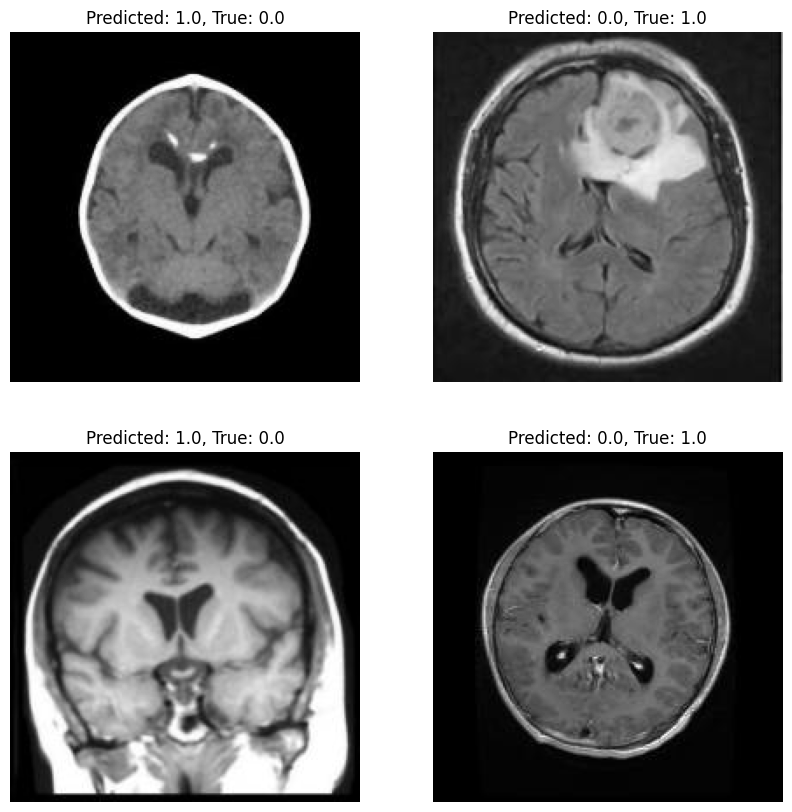

In [19]:
show_misclassified_images(binary_misclassified_images)

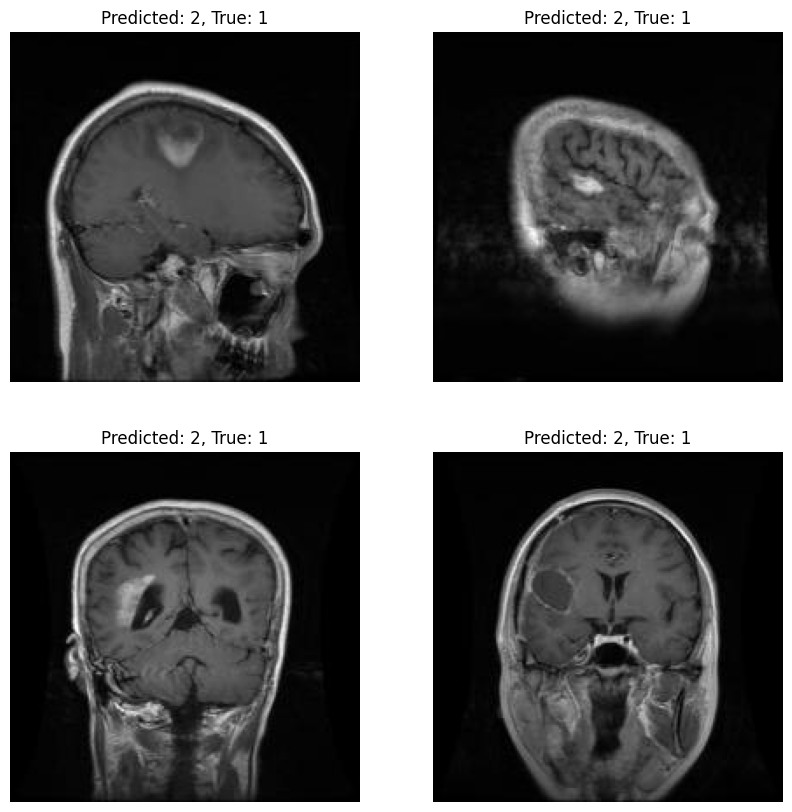

In [20]:
show_misclassified_images(multiclass_misclassified_images)

### Get the feature maps

In [21]:
feature_maps_binary = {}
feature_maps_multiclass = {}

def get_feature_maps_binary(module, input, output):
    feature_maps_binary[module] = output.detach()

def get_feature_maps_multiclass(module, input, output):
    feature_maps_multiclass[module] = output.detach()

def register_hooks(model, model_type):
    if model_type == "binary":
        for name, layer in model.named_modules():
            if isinstance(layer, nn.Conv2d):
                layer.register_forward_hook(get_feature_maps_binary)
    elif model_type == "multiclass":
        for name, layer in model.named_modules():
            if isinstance(layer, nn.Conv2d):
                layer.register_forward_hook(get_feature_maps_multiclass)

# Register hooks for both models
register_hooks(binary_model, "binary")
register_hooks(multiclass_model, "multiclass")

In [22]:
def visualize_layer_feature_maps(layer_feature_maps, num_maps=3, title="Feature Maps"):
    """
    Visualize the first 'num_maps' feature maps of a given layer.
    """
    fig, axes = plt.subplots(1, num_maps, figsize=(12, 3))
    for i, feature_map in enumerate(layer_feature_maps[0][:num_maps]):
        axes[i].imshow(feature_map.cpu(), cmap='gray')
        axes[i].axis('off')
    fig.suptitle(title)
    plt.show()

def forward_pass_and_visualize(model, test_loader, feature_map, title):
    images, _ = next(iter(test_loader))  # Get a batch of images
    image = images[0:1].to(device)  # Take the first image from the batch, ensure it's a single image batch

    # Perform a forward pass to activate the hooks and capture the feature maps
    model.eval()
    with torch.no_grad():
        _ = model(image)

    layers = list(feature_map.keys())
    for i, layer in enumerate(layers[:3]):  # Visualize the first three layers
        visualize_layer_feature_maps(feature_map[layer], title=f"Layer {i + 1} Feature Maps")

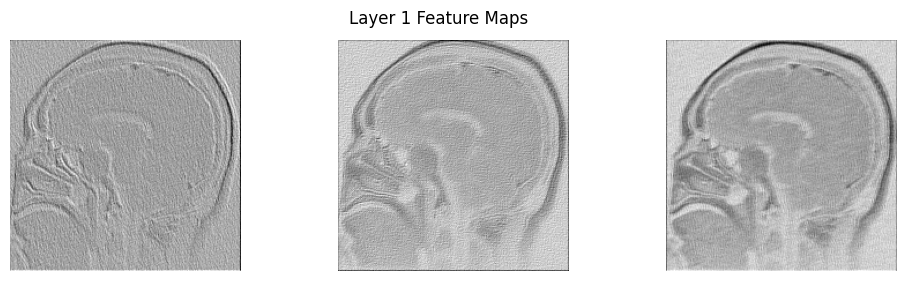

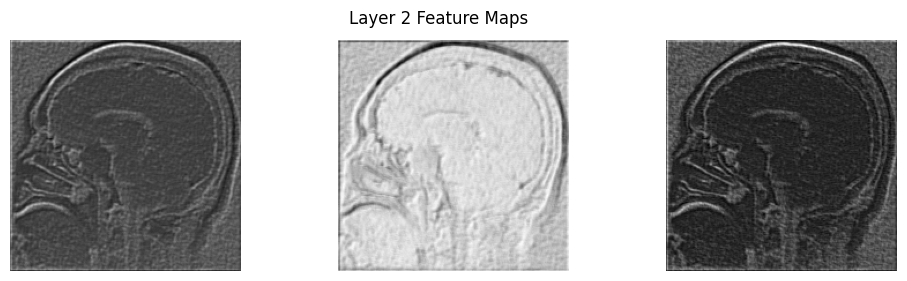

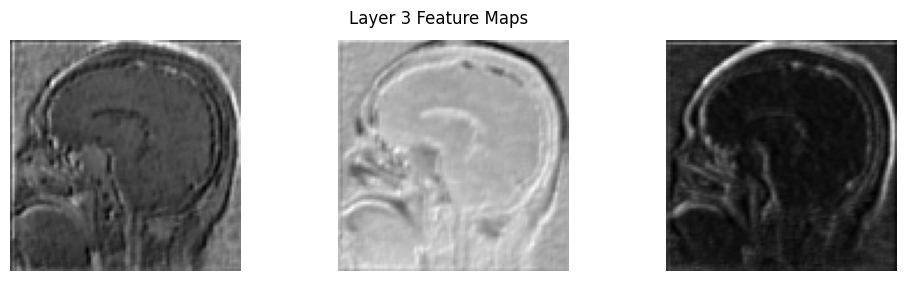

In [23]:
forward_pass_and_visualize(binary_model, binary_training, feature_maps_binary, "Binary")

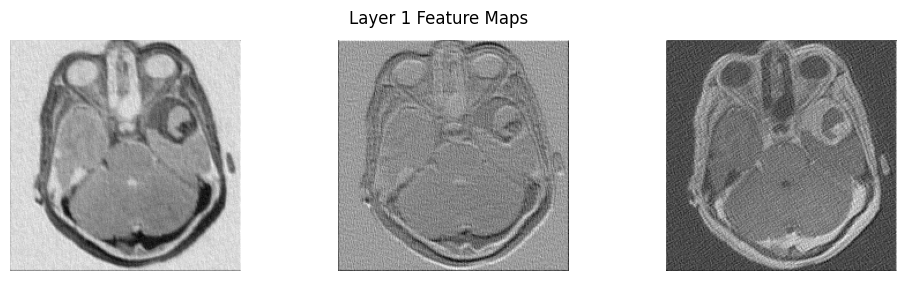

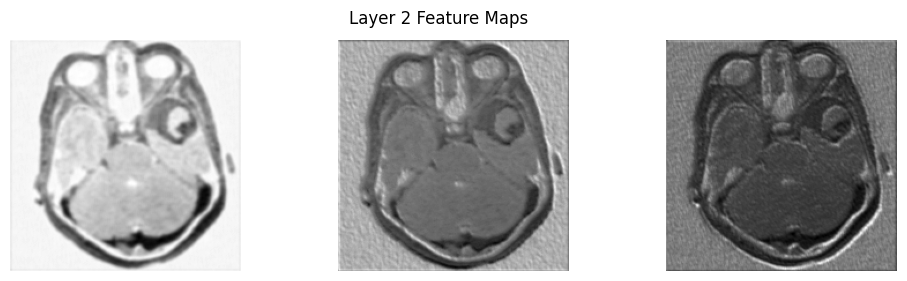

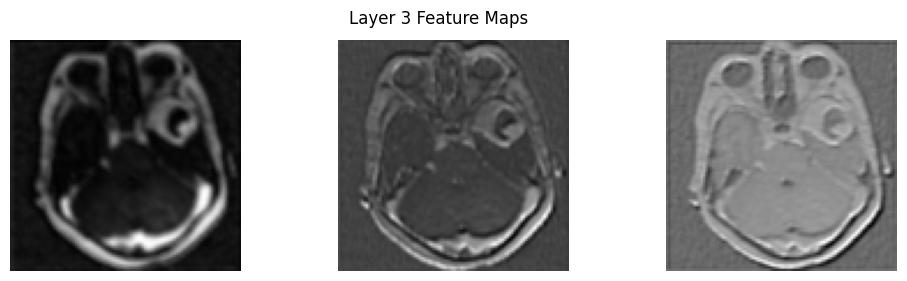

In [24]:
forward_pass_and_visualize(multiclass_model, multi_training, feature_maps_multiclass, "Multiclass")